# Laboratorium 5 - Graph Neural Network

In [ ]:
%pip install torch_geometric

Ważne elementy konstruowania klasy GCN w PyTorch Geometrics:

* **class GCN(torch.nn.Module):** definiuje klasę GCN dziedziczącą po klasie torch.nn.Module.**
* **def __init__(self, hidden_channels):**definiuje konstruktor dla klasy GCN. Konstruktor ten przyjmuje jeden argument hidden_channels, który określa liczbę kanałów ukrytych.
* **super(GCN, self).__init__():** wywołuje konstruktor klasy nadrzędnej, czyli torch.nn.Module.
* **torch.manual_seed(12345)** ustawia seed dla generatora liczb losowych w PyTorch, co zapewnia, że wyniki będą deterministyczne i powtarzalne przy każdym uruchomieniu programu.
* **self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)** definiuje pierwszą warstwę konwolucyjną, gdzie dataset.num_node_features określa liczbę cech wejściowych, a hidden_channels określa liczbę kanałów ukrytych.
* **self.lin = Linear(hidden_channels, dataset.num_classes)** definiuje warstwę liniową klasyfikatora, gdzie hidden_channels to liczba wejściowych kanałów, a dataset.num_classes to liczba klas, które chcemy przewidzieć.


# 1. Podstawy GNN (Karate Club)




Zapoznaj się z dokumentacja PyTorch Geometrics. Dokonaj modyfikacji w budowaniu architektury sieci GNN oraz procesu jej uczenia (Optymalizatory, funkcje aktywacji, funkcje straty). Zaproponuj dodanie Early Stoppingu do tego modelu (działanie takie samo jak w Kerasie ale trzeba zaimplementować to ręcznie) . Podziel kod na odseparowane komórki żeby wyglądał bardziej składnie i czytelnie.

In [3]:
# Funkcja do rysowania grafu oryginalnego
import networkx as nx

def draw_true_graph(G):
    pos = nx.spring_layout(G, seed=42)
    colors = ['#1f78b4' if data.y[i] == 0 else '#33a02c' for i in range(G.number_of_nodes())]
    plt.subplot(1, 2, 1)
    nx.draw(G, pos=pos, with_labels=True, node_color=colors, edgecolors='gray')
    plt.title('True Labels')

# Wyświetl predykcje
def draw_graph_predict(G, pred):
    pos = nx.spring_layout(G, seed=42)
    colors = ['#1f78b4' if p == 0 else '#33a02c' for p in pred]
    plt.subplot(1, 2, 2)
    nx.draw(G, pos=pos, with_labels=True, node_color=colors, edgecolors='gray')
    plt.title('Predicted Labels')
    plt.show()


Epoch 0: Train Accuracy: 0.1000


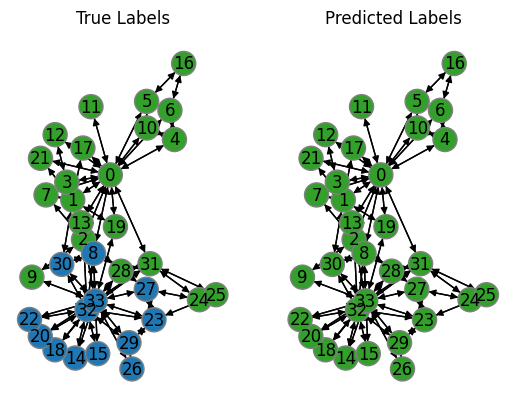

Epoch 1: Train Accuracy: 0.1000


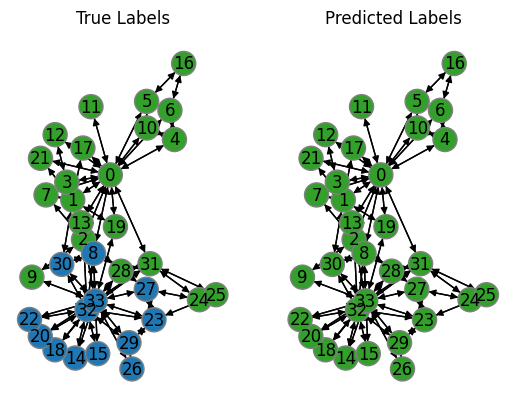

Epoch 2: Train Accuracy: 0.1000


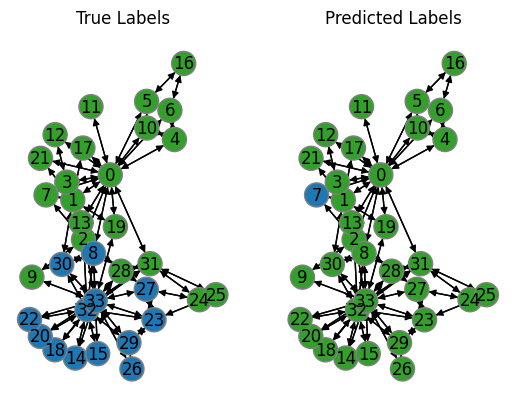

Epoch 3: Train Accuracy: 0.1000


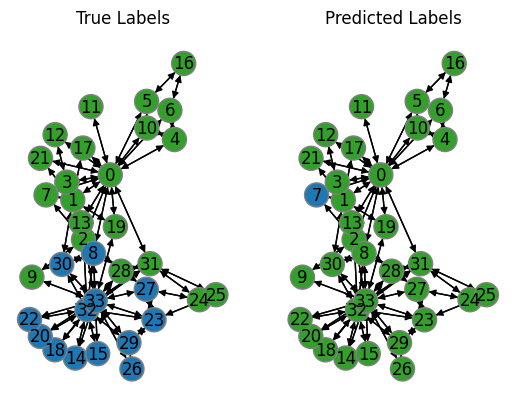

Epoch 4: Train Accuracy: 0.1000


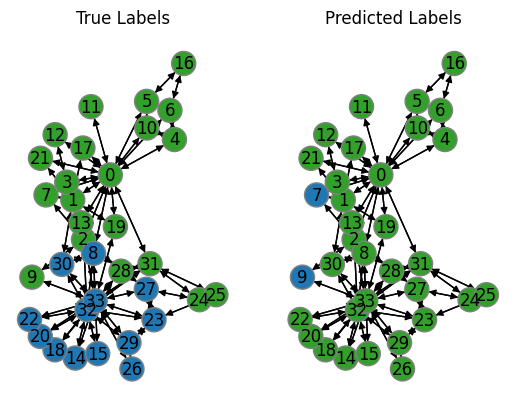

Epoch 5: Train Accuracy: 0.1000


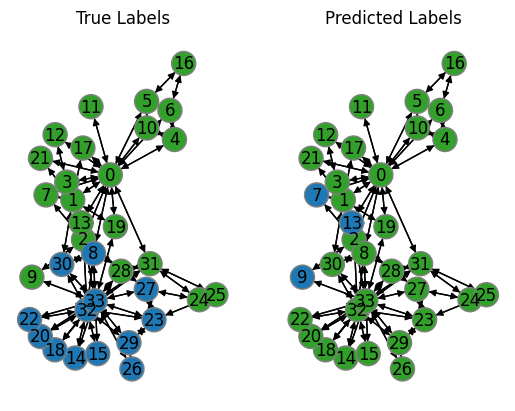

Epoch 6: Train Accuracy: 0.1000


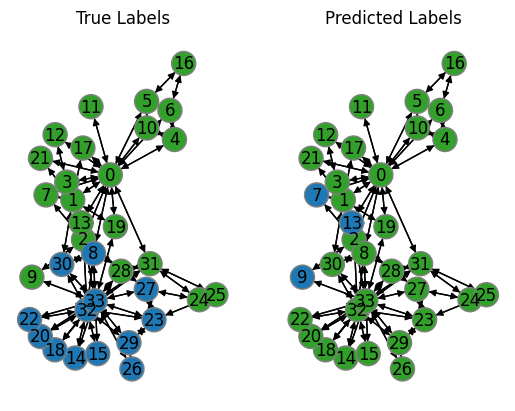

Epoch 7: Train Accuracy: 0.1000


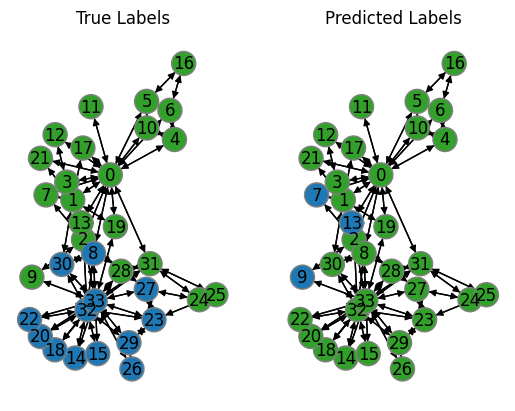

Epoch 8: Train Accuracy: 0.1000


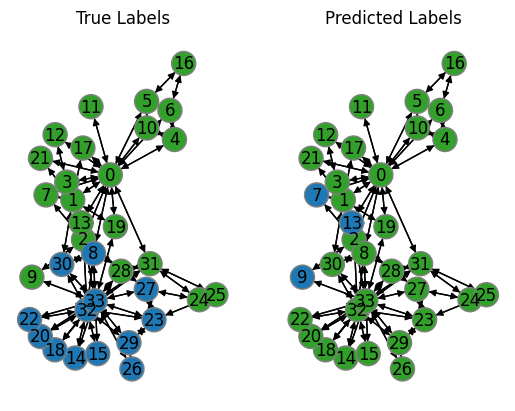

Epoch 9: Train Accuracy: 0.1000


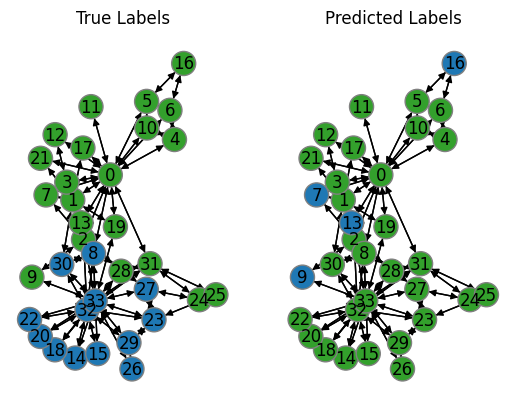

Epoch 10: Train Accuracy: 0.1000


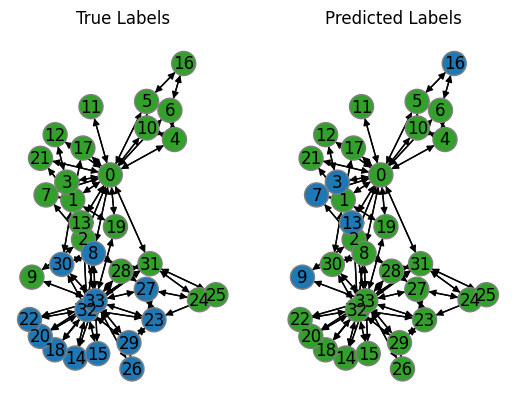

Epoch 11: Train Accuracy: 0.2000


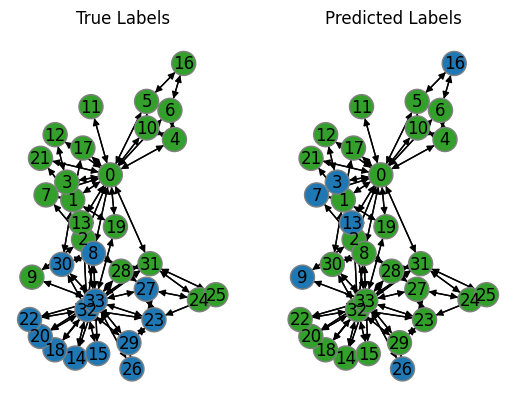

Epoch 12: Train Accuracy: 0.2000


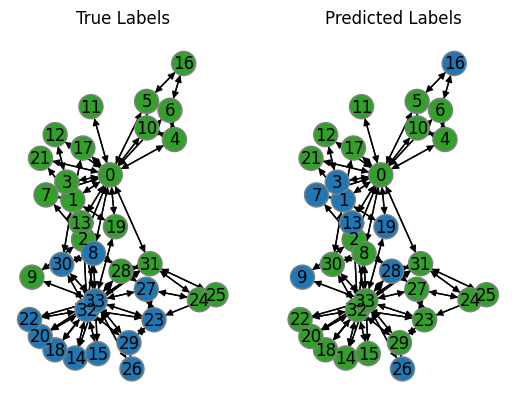

Epoch 13: Train Accuracy: 0.3000


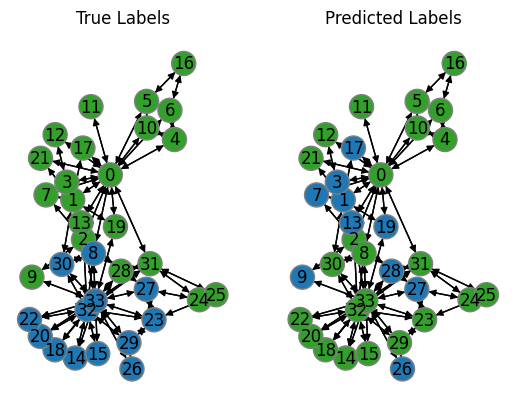

Epoch 14: Train Accuracy: 0.3000


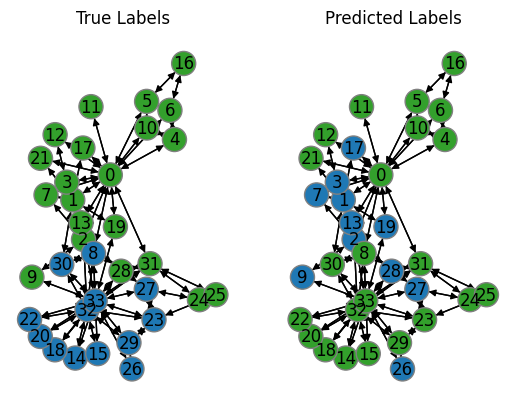

Epoch 15: Train Accuracy: 0.3000


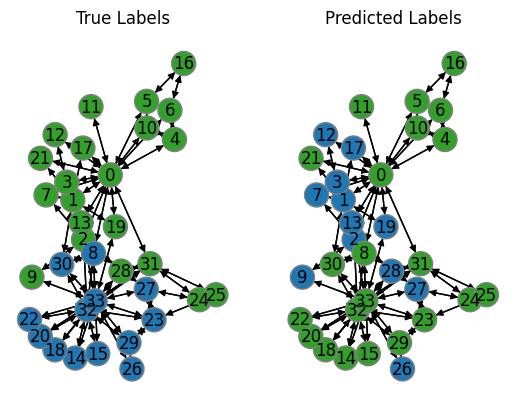

Epoch 16: Train Accuracy: 0.3000


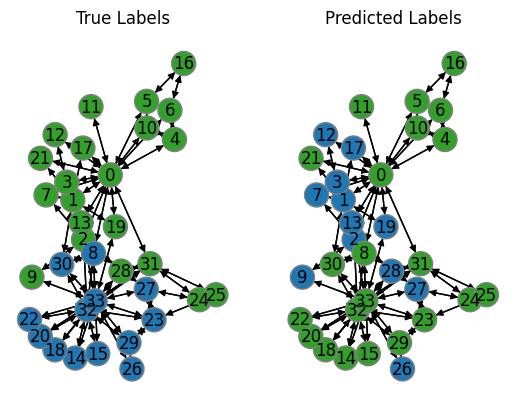

Epoch 17: Train Accuracy: 0.3000


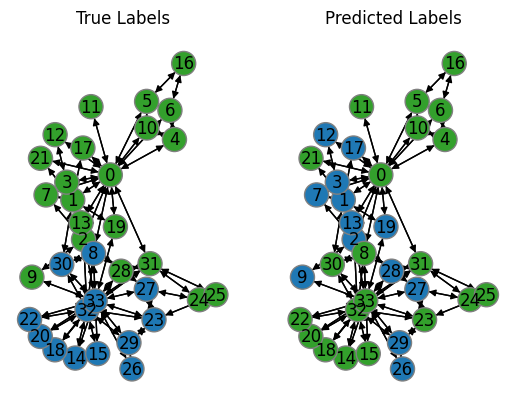

Epoch 18: Train Accuracy: 0.3000


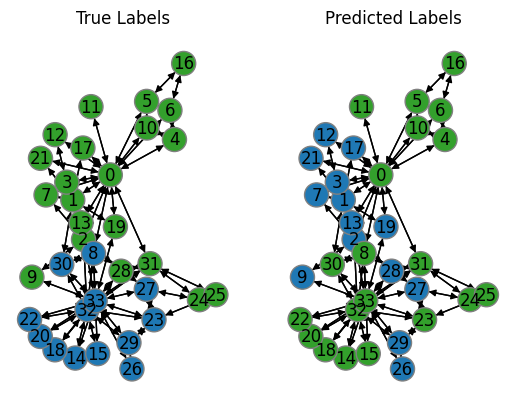

Epoch 19: Train Accuracy: 0.3000


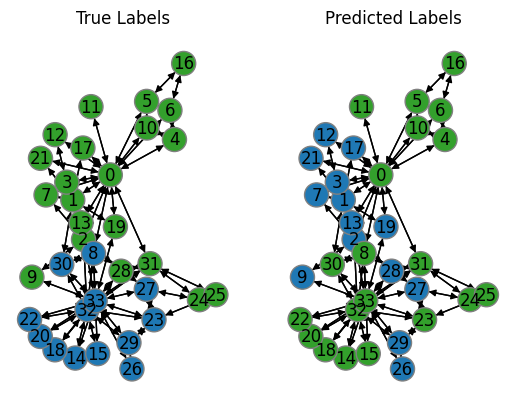

Epoch 20: Train Accuracy: 0.4000


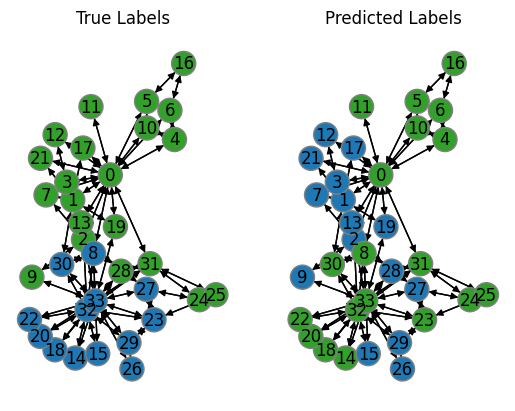

Epoch 21: Train Accuracy: 0.4000


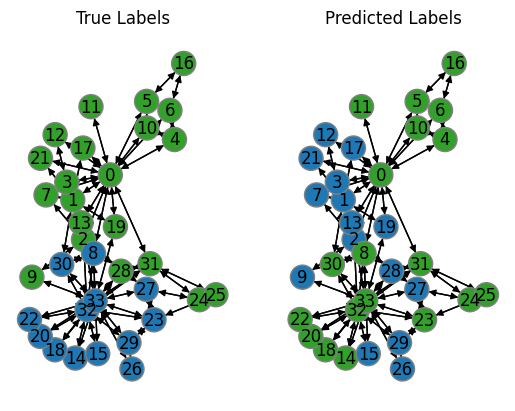

Epoch 22: Train Accuracy: 0.4000


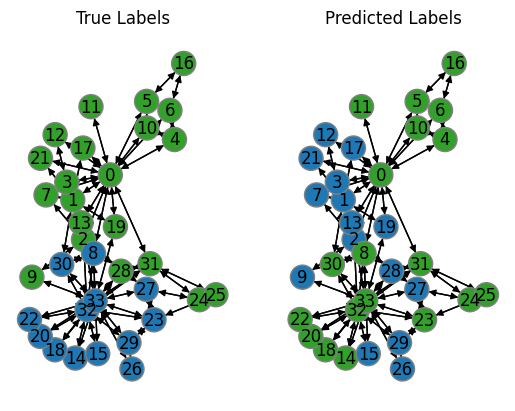

Epoch 23: Train Accuracy: 0.4000


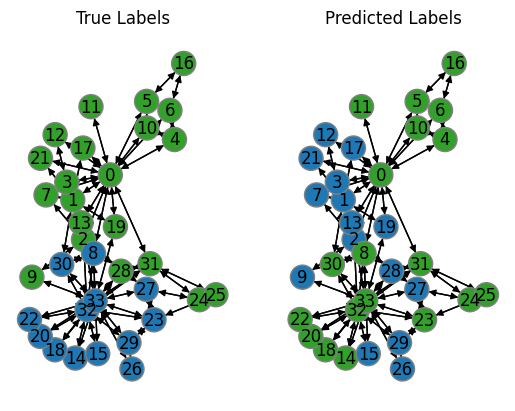

Epoch 24: Train Accuracy: 0.4000


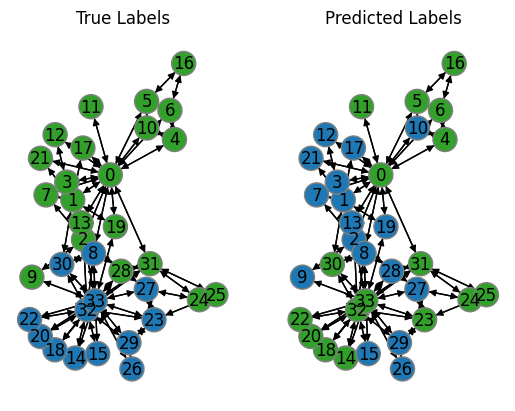

Epoch 25: Train Accuracy: 0.5000


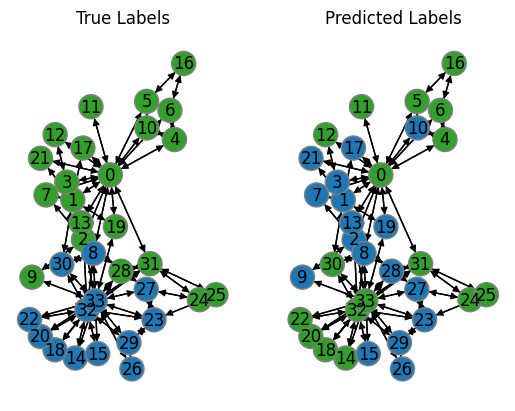

Epoch 26: Train Accuracy: 0.5000


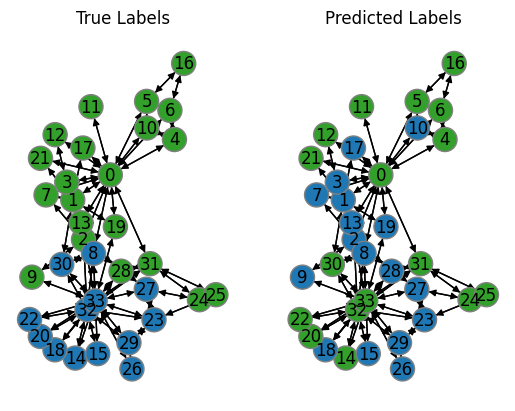

Epoch 27: Train Accuracy: 0.5000


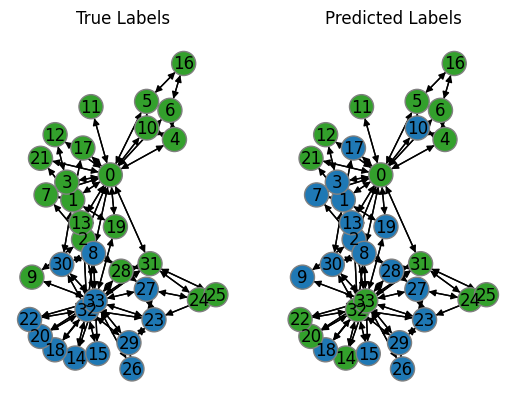

Epoch 28: Train Accuracy: 0.5000


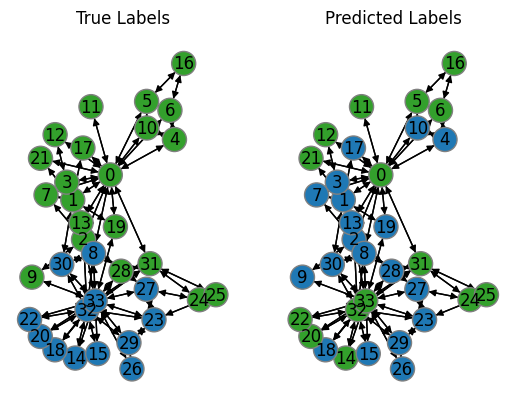

Epoch 29: Train Accuracy: 0.5000


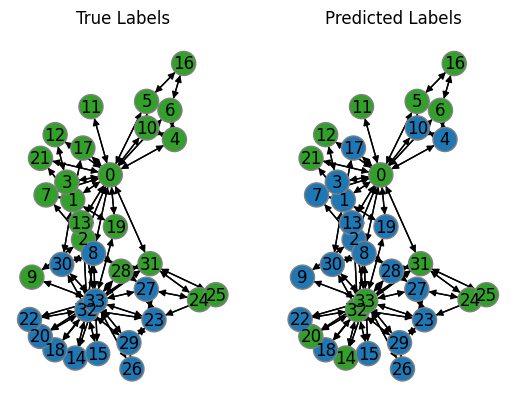

Final Training Accuracy: 0.5000
Predicted Class Labels: tensor([2, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 1, 1, 0, 2, 0, 3, 0, 0, 0, 2, 1, 0, 0,
        2, 2, 0, 0, 0, 0, 0, 2, 2, 2])


In [4]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import KarateClub
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader

# Załaduj zbiór danych Karate Club
dataset = KarateClub()

# Wczytaj pierwszy graf z zestawu danych
data = dataset[0]

# Wyznacz losowo 10 węzłów uczących się
import random
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.train_mask[random.sample(range(data.num_nodes), 10)] = 1

# Zdefiniuj model GNN
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)  # pierwsza warstwa konwolucyjna na wejściu x i krawędziach edge_index
        x = F.relu(x)  # nieliniowa funkcja aktywacji - ReLU
        x = F.dropout(x, training=self.training)  # regularyzacja - dropout
        x = self.conv2(x, edge_index)  # druga warstwa konwolucyjna na wyjściu z poprzedniej warstwy i krawędziach edge_index
        return F.log_softmax(x, dim=1)  # funkcja softmax zwracająca prawdopodobieństwa przynależności do klas, zwracana wartość jest zlogarytmowana (log_softmax)


# Zainicjuj model i funkcję kosztu
model = Net()
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

# Konwertuj dane na graf
G = to_networkx(data)

from torch_geometric.utils.convert import to_networkx

for epoch in range(30):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    model.eval()
    pred = model(data.x, data.edge_index).argmax(dim=1)
    acc = (pred[data.train_mask] == data.y[data.train_mask]).float().mean()
    print(f'Epoch {epoch}: Train Accuracy: {acc:.4f}')

    draw_true_graph(to_networkx(data))
    draw_graph_predict(to_networkx(data), pred)


# Ustaw model w tryb ewaluacji i wyświetl wyniki
model.eval()
pred = model(data.x, data.edge_index).argmax(dim=1)
acc = (pred[data.train_mask] == data.y[data.train_mask]).float().mean()
print(f'Final Training Accuracy: {acc:.4f}')

# Wyświetl wyniki klasyfikacji dla wszystkich węzłów
pred = model(data.x, data.edge_index).argmax(dim=1)
print(f'Predicted Class Labels: {pred}')


# 2. Texas Dataset (WebKG)

Dokonaj podobnych modyfikacji jak w datasecie Karate Club. Coś się zmieniło? Jak to wpływa na finalny wynik?

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

def draw_true_graph_texas(G):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx_nodes(G, pos, node_color=data.y, cmap='Set1', node_size=500)
    nx.draw_networkx_edges(G, pos)
    plt.title("True Graph")
    plt.show()

def draw_graph_predict_texas(G, pred):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx_nodes(G, pos, node_color=pred, cmap='Set1', node_size=500)
    nx.draw_networkx_edges(G, pos)
    plt.title("Predicted Graph")
    plt.show()


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import WebKB
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader

# Load the WebKB dataset
dataset = WebKB(root='.', name='texas')

# Load the first graph from the dataset
data = dataset[0]

# Randomly select 10 nodes as training nodes
import random
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.train_mask[random.sample(range(data.num_nodes), 10)] = 1

# Define the GNN model
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize the model and loss function
model = Net()
criterion = torch.nn.NLLLoss()

# Define the optimizer and train for 200 epochs
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

# Convert the data to a networkx graph
G = to_networkx(data)

# Training loop with classification output for each epoch
for epoch in range(30):
    print(f"---------------------------- EPOCH: {epoch}---------------------------------------")
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    model.eval()
    pred = model(data.x, data.edge_index).argmax(dim=1)
    acc = (pred[data.train_mask] == data.y[data.train_mask]).float().mean()
    print(f'Epoch {epoch}: Train Accuracy: {acc:.4f}')

    # Draw the true graph and the predicted graph
    draw_true_graph_texas(to_networkx(data))
    draw_graph_predict_texas(to_networkx(data), pred)

    print("-------------------------------------------------------------------")


# Set the model to evaluation mode and display the results
model.eval()
pred = model(data.x, data.edge_index).argmax(dim=1)
acc = (pred[data.train_mask] == data.y[data.train_mask]).float().mean()
print(f'Final Training Accuracy: {acc:.4f}')

# Display the classification results for all nodes
pred = model(data.x, data.edge_index).argmax(dim=1)
print(f'Predicted Class Labels: {pred}')


# 2. [Cora Dataset](https://graphsandnetworks.com/the-cora-dataset/)
Bardzo brzydko rysuje grafy i trwa dość długo - ale jak ktoś ma ochote poznac bardziej bibliotekę PyTorch Geometrics i GNN to polecam zainteresować się datasetami Cora, PubMed oraz CiteSeer  (dostępne z poziomu biblioteki PyTorch Geometrics)

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

def draw_true_graph_cora(G):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx_nodes(G, pos, node_color=data.y, cmap='Set1', node_size=500)
    nx.draw_networkx_edges(G, pos)
    plt.title("True Graph")
    plt.show()

def draw_graph_predict_cora(G, pred):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx_nodes(G, pos, node_color=pred, cmap='Set1', node_size=500)
    nx.draw_networkx_edges(G, pos)
    plt.title("Predicted Graph")
    plt.show()


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader
import random


from torch_geometric.datasets import Planetoid
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.train_mask[random.sample(range(data.num_nodes), 100)] = 1


# Zdefiniuj model GNN
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 64)
        self.conv2 = GCNConv(64, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Zainicjuj model i funkcję kosztu
model = Net()
criterion = torch.nn.NLLLoss()

# Zdefiniuj optymalizator i uczenie przez 200 epok
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)


import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

# Konwertuj dane na graf
G = to_networkx(data)

from torch_geometric.utils.convert import to_networkx

# Pętla ucząca z wyświetlaniem klasyfikacji za każdą epoką
for epoch in range(30):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    model.eval()
    pred = model(data.x, data.edge_index).argmax(dim=1)
    acc = (pred[data.train_mask] == data.y[data.train_mask]).float().mean()
    print(f'Epoch {epoch}: Train Accuracy: {acc:.4f}')

    draw_true_graph_cora(to_networkx(data))
    draw_graph_predict_cora(to_networkx(data), pred)


# Ustaw model w tryb ewaluacji i wyświetl wyniki
model.eval()
pred = model(data.x, data.edge_index).argmax(dim=1)
acc = (pred[data.train_mask] == data.y[data.train_mask]).float().mean()
print(f'Final Training Accuracy: {acc:.4f}')

# Wyświetl wyniki klasyfikacji dla wszystkich węzłów
pred = model(data.x, data.edge_index).argmax(dim=1)
print(f'Predicted Class Labels: {pred}')

# 3. Klasyfikacja grafów (nie węzłów) z datasetem MUTAG

Bardzo brzydko rysuje grafy ale nie trwa jakoś długo. Do wizualizacji grafów w sieciach GNN używa sie zewnętrznych narzędzi które to ułatwiają - tutaj niestety NetworkX jest niewystarczające.

Twoim zdaniem będzie sprawdzić wpływ większej ilości warstw GCN w modelu. Spróbuj dodać/usunąć warstwe.

In [ ]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import networkx as nx

def visualize_graph_classification(graph, true_label, predicted_label):
    G = nx.Graph()
    G.add_nodes_from(range(graph.num_nodes))
    G.add_edges_from(graph.edge_index.t().tolist())

    node_colors = []
    if len(true_label) == graph.num_nodes:
        for i in range(graph.num_nodes):
            if true_label[i] == 1:
                node_colors.append('red')
            else:
                node_colors.append('blue')
    else:
        node_colors = ['blue'] * graph.num_nodes

    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color=node_colors)
    plt.title(f"Predicted label: {predicted_label}")
    plt.show()



In [ ]:
# Import biblioteki PyTorch oraz klasy TUDataset z biblioteki torch_geometric.datasets
import torch
from torch_geometric.datasets import TUDataset

# Pobierz zbiór danych MUTAG z bazy TUDataset
dataset = TUDataset(root='data/TUDataset', name='MUTAG')

# Wyświetl informacje o zbiorze danych MUTAG
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}') # Liczba grafów w zbiorze danych
print(f'Number of features: {dataset.num_features}') # Liczba cech w każdym grafie
print(f'Number of classes: {dataset.num_classes}') # Liczba klas, na które można podzielić grafy

# Pobierz pierwszy graf z dataset
data = dataset[0]

# Wyświetl informacje o pierwszym grafie
print()
print(data) # Wyświetl informacje o pierwszym grafie
print('=============================================================')

# Oblicz niektóre statystyki dla pierwszego grafu
print(f'Number of nodes: {data.num_nodes}') # Liczba węzłów w grafie
print(f'Number of edges: {data.num_edges}') # Liczba krawędzi w grafie
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}') # Średni stopień węzła
print(f'Has isolated nodes: {data.has_isolated_nodes()}') # Czy graf zawiera izolowane węzły?
print(f'Has self-loops: {data.has_self_loops()}') # Czy graf zawiera pętle?
print(f'Is undirected: {data.is_undirected()}') # Czy graf jest nieskierowany?

# Ustaw ziarno losowości dla biblioteki PyTorch
torch.manual_seed(12345)

# Przetasuj zbiór danych MUTAG
dataset = dataset.shuffle()

# Podziel zbiór danych na zbiór treningowy i testowy
train_dataset = dataset[:150]
test_dataset = dataset[150:]

# Wyświetl informacje o podziale zbioru danych
print(f'Number of training graphs: {len(train_dataset)}') # Liczba grafów w zbiorze treningowym
print(f'Number of test graphs: {len(test_dataset)}') # Liczba grafów w zbiorze testowym

# Załaduj dane z podzielonego zbioru danych do DataLoader
from torch_geometric.loader import DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) # DataLoader dla zbioru treningowego
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False) # DataLoader dla zbioru testowego

# Zdefiniuj model GCN
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)  # pierwsza warstwa konwolucyjna
        self.conv2 = GCNConv(hidden_channels, hidden_channels)  # druga warstwa konwolucyjna
        self.conv3 = GCNConv(hidden_channels, hidden_channels)  # trzecia warstwa konwolucyjna
        self.lin = Linear(hidden_channels, dataset.num_classes)  # warstwa liniowa klasyfikatora

    def forward(self, x, edge_index, batch):
        # 1. Obliczenie osadzeń węzłów
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Warstwa agregacji
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Zastosowanie klasyfikatora
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

model = GCN(hidden_channels=64)  # Tworzenie obiektu reprezentującego GCN o rozmiarze warstwy ukrytej 64
print(model)


model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Definicja optymalizatora Adam
criterion = torch.nn.CrossEntropyLoss()  # Definicja funkcji kosztu CrossEntropyLoss

def train():
    model.train()  # Ustawienie modelu w trybie treningowym

    for data in train_loader:  # Iteracja po danych treningowych w paczkach
         out = model(data.x, data.edge_index, data.batch)  # Wykonanie jednego przejścia sieci
         loss = criterion(out, data.y)  # Obliczenie funkcji kosztu
         loss.backward()  # Obliczenie gradientów
         optimizer.step()  # Aktualizacja parametrów na podstawie gradientów
         optimizer.zero_grad()  # Wyczyszczenie gradientów

def test(loader):
     model.eval()  # Ustawienie modelu w trybie testowym

     correct = 0
     for data in loader:  # Iteracja po danych testowych w paczkach
         out = model(data.x, data.edge_index, data.batch)
         pred = out.argmax(dim=1)  # Użycie klasy z najwyższym prawdopodobieństwem
         correct += int((pred == data.y).sum())  # Sprawdzenie z etykietami prawdziwymi
     return correct / len(loader.dataset)  # Obliczenie wskaźnika poprawności predykcji


for epoch in range(1, 171):
    print(f"------------------------------ START {epoch}------------------------------")
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)

    # Add visualization code here
    for data in train_loader:
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        visualize_graph_classification(data, data.y.tolist(), pred.tolist())

    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

    print(f"------------------------------ END {epoch}------------------------------")


# Zadanie

1. Zaproponuj siec CNN albo MLP do rozwiazania zadania z datasetem Karate Club. Porównaj wyniki - jakie masz obserwacje?

2. Zamiast dataset Cora, wykorzystaj dataset CiteSeer i PubMed ze zbioru `Planetoid` i zaimplementuj siec GCN.

3. Zamiast datasetu MUTAG wykorzystaj dataset ENZYMES i PROTEINS ze `TuDataset`

4. Zaimplementuj siec GCN oraz [GAT](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.models.GAT.html). Porownaj wyniki ze soba. Zastosuj [Mini-batching]((https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb?usp=sharing) do obu datasetow

5. Zaimplementuj siec [GIN](https://colab.research.google.com/drive/1b6SWugNKnxsI0L9auX1zwszlXf3rRZyS?usp=sharing) dla datasetow MUTAG, ENZYMES i PROTEINS. Porownaj uzyskane wyniki.

6. Scharakteryzuj roznice pomiedzy GIN, GAT a GCN. Omów je odnosząc sie do sieci CNN.

7. Zaproponuj inna metode wizualizacji grafów (korzystajac np. z networkx itd. Najwazniejsze to pokzac predicted vs true)